# Dual channel oscilloscope

This example shows how a signal can be captured using a dual channel oscilloscope.

**Note:**  
Voltage range of fast analog inputs on the Red Pitaya depends on gain setting that can be set by jumpers. HV setting is for input range to ±20V, while LV sets input range to ±1V. For more information please read the following [chapter](http://redpitaya.readthedocs.io/en/latest/doc/developerGuide/125-14/fastIO.html#analog-inputs). 

Create a loop back from fast outputs to the fast inputs as shown in the picture below.  
Make sure that *gain setting* is set to ±1V (LV).

![Fast loop back](img/FastIOLoopBack.png "Example of the fast loop back.")

Now start generation of the signal from the [generator notebook](gen_sync_two_channel.ipynb). Execute all cells except the last one which will disable the outputs. It is recommended that you run it when you finish with this example.

In [1]:
import json, time
import paho.mqtt.publish as publish
def sendMessage(**kwargs):
    #print('called')
    valDict = kwargs
    valDict['messageid'] = 'beamOn'
    #valDict['timestamp'] = time.time()
    msgjson = json.dumps(valDict)
    #print('called2')
#     with open("messageRecord.txt", 'w+') as f:
#         f.write(msgjson)
    publish.single('Tiago/ISIS/vals', msgjson,
                hostname='icxparrot.isis.rl.ac.uk',port=1883,
                client_id='vista_pub_synctest2',
                auth={'username':'controls', 'password':'controls'})
        
#vista/set/test2/an_int/values

In [105]:
# msgjson = json.dumps({"value": 93, "messageid":"1345", "timestamp":time.time()})
 
# publish.single('vista/set/test2/an_int/value', msgjson,
#             hostname='icxparrot.isis.rl.ac.uk',port=1883,
#             client_id='vista_pub_synctest2',
#             auth={'username':'controls', 'password':'controls'})



# time.time()

1575372939.776914

In [2]:
import matplotlib.pyplot as plt
import time
from redpitaya.overlay.mercury import mercury as overlay
fpga = overlay()

Requested overlay is already loaded.


Make instance of both oscilloscope channels.

In [3]:
osc0 = fpga.osc(0, 20.0)
osc1 = fpga.osc(1, 20.0) 
osc = [osc0,osc1]
la = fpga.la()

In [4]:
# input mask and polarity
la.input_mask     = 0xffff
la.input_polarity = 0x0000

# data rate decimation
la.decimation = 1

# trigger timing [sample periods]
N = la.buffer_size
la.trigger_pre  = N//4 * 1
la.trigger_post = N//4 * 3

# trigger bit mask, bit values and edges ['neg', 'pos']
la.trigger_mask  =  0x0000
la.trigger_value =  0x0000
la.trigger_edge  = [0x0100, 0x0000]  # enable trigger on edge [pos, neg]

# trigger source is the level trigger from the same input
la.trig_src = fpga.trig_src["la"]

User should specify the same timing settings for both channels:
1. Sample rate decimation is an integer in range [1, 2\*\*17] = [1, 131072].
2. Number of samples stored before and after trigger, for a forced trigger only post trigger samples are enough.

Both channels should also have the same synchronization setting.
This enables controlling reset/start/stop/trigger events for both channels by calling control functions for a single channel.

In [5]:
osc0.decimation = 125
N = 1200#ch.buffer_size   # 1200 points at 1 us captures 1.2 ms of pulse data
osc0.trigger_pre  = 1*N//12
osc0.trigger_post = 11*N//12

# osc1.decimation = 125
# osc1.trigger_pre  = 1*N//12
# osc1.trigger_post = 11*N//12

# # osc[1] is controlling both channels
# osc1.sync_src = fpga.sync_src["osc0"]

fundamentalSampleRate = 8e-9
sampleRate = fundamentalSampleRate*osc[0].decimation
captureDuration = sampleRate*N


In [6]:
captureDuration


0.0012000000000000001

Trigger level settings can be configured for each channel separately.

In [6]:
# trigger level [V], edge ['neg', 'pos']
# hysteresis is used to avoid triggering on wrong edge with noisy signals

# trigger on 0.5V but do not trigger again unless signal first falls below 0.45V
osc[0].level = [0.1, 0.2]
osc[0].edge  = 'pos'

# trigger on -0.2V but do not trigger again unless signal first rises above -0.15V
# osc[1].level = [0.9, 1]
# osc[1].edge  = 'pos'

Both channels should have the same trigger source which should be one of the channels. Only trigger level settings for the selected channel are relevant.

In [7]:
# for ch in osc:
#     ch.trig_src = fpga.trig_src["la"]
osc[0].trig_src = fpga.trig_src["la"]

The oscilloscope should be reset and started by calling functions from the master oscilloscope module.
A loop is checking if a hardware trigger has arrived and if the desired number of data samples was already stored in the buffer. Since both channels were programmed with the same timing setting they both stop at the same time.

Data should be read from both channels.


In [ ]:
import numpy as np
from datetime import datetime  

while True:
    beamTwoSecCounter = 0
    for i in range(100):
        osc[0].reset()
        osc[0].start()
        while (osc[0].status_run()): pass
        beamarray = osc[0].data(N)
        if (len(beamarray[(beamarray > -0.1)]) < 180): # identify bad pulses - if less than 800 points are below 0.5V, fail
            beamTwoSecCounter = beamTwoSecCounter + 1
             
    sendMessage(value = beamTwoSecCounter, timestamp=time.time())

    
# tEnd = time.time()

# fullTime = tEnd - tStart
# triggerTime = tTrig - tStart
# processingTime = tEnd - tTrig
# print('total time: ' + str(fullTime) + ' triggerTime: ' + str(int(1e6*triggerTime)) + ' processing Time: ' + str(int(processingTime*1e6)))


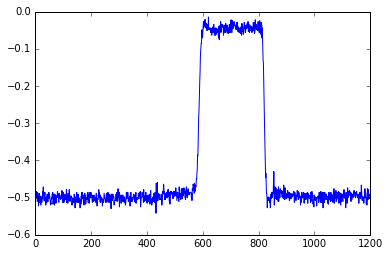

In [11]:
plt.figure()

plt.plot(beamarray)
plt.show()

#jupyter ncconvert --execute CopyPulseCounter.pynb